In [3]:
import torch 
import datasets 
import torch.nn as nn 
from tqdm import tqdm 

import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from collections import Counter
from datasets import load_dataset

d:\anaconda\envs\nlp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\пользователь\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
dataset = load_dataset('IlyaGusev/gazeta', revision="v1.0", trust_remote_code=True)

Generating validation split: 100%|██████████| 5265/5265 [00:00<00:00, 7019.51 examples/s]


In [7]:
dataset['validation']['text']

['После громких приобретений Андре Шюррле, Гуса Тиля, Эсекьеля Понсе и Джордана Ларссона , а также покупки Резиуана Мирзова московский «Спартак» не планирует закрывать свою летнюю трансферную кампанию. Красно-белые, усилив атакующую линию, взялись за укрепление центральной зоны. Особенно актуальным данный вопрос стал после ухода бразильского хавбека Фернадо в китайский «Бэйцзин Гоань». Тепень за оборонительные действия в «Спартаке» отвечают Роман Зобнин и Аяз Гулиев , однако их игра вызывает больше негативных оценок, нежели уверенности за результат. В связи с провальными переговорами с чешской «Славией» по покупке опорных полузащитников Алекса Крала и Томаша Соучека представители «народной» команды обратили свой взгляд на чемпионат Франции. Nejvyssi vedeni ruskeho klubu navstivilo v minulych dnech Ceskou republiku. I pri veskerem fotbalem respektu k vyznamu tohoto slavneho klubu Slavia odmitla vubec zahajit i zdvorilostni jednani o obou transferech. Ani jeden nyni neni na prodej. После

In [20]:
from nltk.tokenize import sent_tokenize
def tokenize_sequence(dataset):
    sentences = []
    for sentence in tqdm(dataset['validation']['text']):
        sentences.extend([x.lower() for x in sent_tokenize(sentence, language='russian') if len(x) < 128])
        
    return sentences
        

In [21]:
sentences = tokenize_sequence(dataset=dataset)

100%|██████████| 5265/5265 [00:06<00:00, 768.44it/s]


In [22]:
len(sentences)

122237

In [26]:
counter = Counter()

for sentence in tqdm(sentences):
    for char in sentence:
        counter[char] +=1
        
len(counter)
        
    
    

100%|██████████| 122237/122237 [00:04<00:00, 25469.48it/s]


132

In [29]:
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
treshhold = 500
for word, count in tqdm(counter.items()):
    if count > treshhold:
        vocab.add(word)
len(vocab)

100%|██████████| 132/132 [00:00<00:00, 132072.55it/s]


86

In [31]:
char2ind = {char : i for i, char in enumerate(vocab)}
ind2char = {i : char for char, i in char2ind.items()}

In [33]:
class WordDataset:
    def __init__(self, sentences):
        self.unk_id = char2ind['<unk>']
        self.pad_id = char2ind['<pad>']
        self.bos_id = char2ind['<bos>']
        self.eos_id = char2ind['<eos>']
        self.sentences = sentences
    
    def __getitem__(self, idx):
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [  char2ind.get(char, self.unk_id) for char in self.sentences[idx]]
        return tokenized_sentence
    
    def __len__(self):
        return len(self.sentences)
    
        

In [35]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [44]:
def collate_fn_with_padding(input_batch, pad_id=char2ind['<pad>']):
    lens = [len(x) for x in input_batch]
    max_length = max(lens)
    new_batch = []
    for sentence in input_batch:
        for _ in range(max_length - len(sentence)):
            sentence.append(pad_id)
        new_batch.append(sentence)
        
    sequences = torch.LongTensor(new_batch).to(device)
    new_batch = {
        'input_ids' : sequences[:, :-1],
        'target_ids' : sequences[:, 1:]
    }
    return new_batch
            

In [45]:
from torch.utils.data import DataLoader

train_sentences, evaluate_sentences = train_test_split(sentences, test_size=0.2)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(evaluate_sentences)

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=256, collate_fn=collate_fn_with_padding)
eval_dataloader = DataLoader(eval_dataset, shuffle=False, batch_size=256, collate_fn=collate_fn_with_padding)



In [46]:
class CharRNN(nn.Module):
    def __init__(self, hidden_dim, vocab_size):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        
        self.foa = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)
        self.projection = nn.Linear(hidden_dim, vocab_size)
        
    def forward(self, input_batch):
        embeddings = self.embeddings(input_batch)
        output, _ = self.rnn(embeddings)
        output = self.dropout(self.linear(self.foa(output)))
        projection = self.projection(self.foa(output))
        
        return projection
        

In [47]:
def evaluate(model, criterion):
    model.eval()
    perplexity = []
    
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            
            perplexity.append(torch.exp(loss).item())
            
    perplexity = sum(perplexity) / len(perplexity)
    
    return perplexity
    

In [50]:
model = CharRNN(256, vocab_size=len(vocab)).to(device)
optimizer = torch.optim.Adam(model.parameters())

criterion = nn.CrossEntropyLoss(ignore_index=char2ind['<pad>'])


Train Loop

In [54]:
num_epochs = 10

losses = []
perplexity = []

print(f'Start training with epochs: {num_epochs}\n')
for epoch in range(num_epochs):
    model.train()
    epoch_loss = []
    for batch in tqdm(train_dataloader, desc='Training epoch : {epoch}'):
        optimizer.zero_grad()
        logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
        
        loss = criterion(logits, batch['target_ids'].flatten())
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())
        
    losses.append(sum(epoch_loss) / len(epoch_loss))
    perplexity.append(evaluate(model=model, criterion=criterion))


        
        
        
        
        
    
    

Start training with epochs: 10



Training epoch : {epoch}: 100%|██████████| 382/382 [00:31<00:00, 12.18it/s]


Metrics

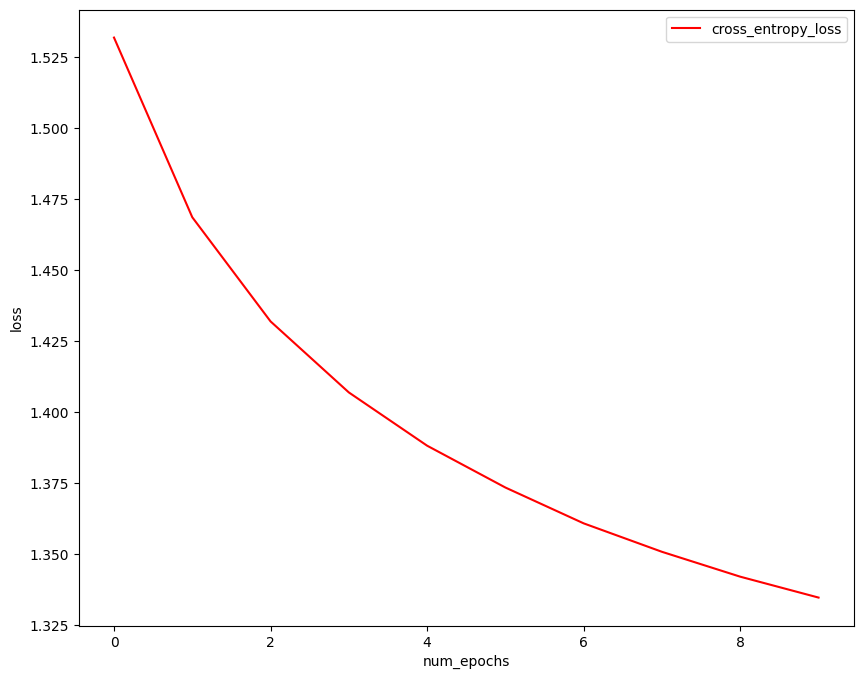

In [69]:
import numpy as np
plt.figure(figsize=(10, 8))
plt.plot(np.arange(num_epochs), losses, color='red', label='cross_entropy_loss')

plt.xlabel('num_epochs')
plt.ylabel('loss')

plt.legend()


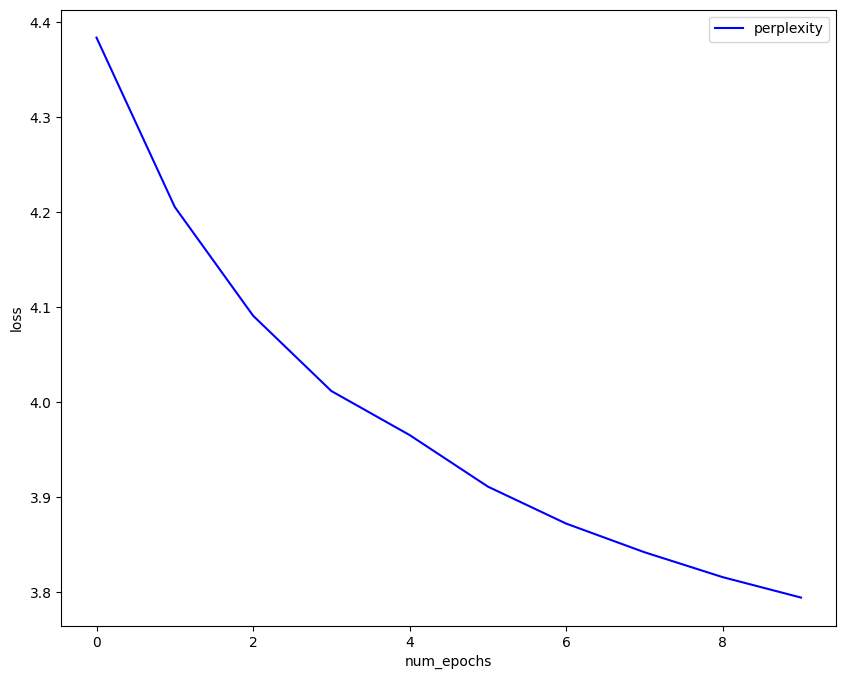

In [70]:
plt.figure(figsize=(10, 8))
plt.plot(np.arange(num_epochs), perplexity, color='blue', label='perplexity')

plt.xlabel('num_epochs')
plt.ylabel('loss')

plt.legend()

Try generate

In [73]:
def generate_sequence(start_seq, model, max_seq_length):
    device = 'cpu'
    start_tokenize = [char2ind['<bos>']] + [char2ind.get(char, char2ind['<unk>']) for char in start_seq]
    input_ids = torch.LongTensor(start_tokenize).to(device)
    
    model.to(device)
    model.eval()
    with torch.no_grad():
        for i in range(max_seq_length):
            char = model(input_ids)[-1]
            next_char = char.squeeze().argmax()
            input_ids = torch.cat([input_ids, next_char.unsqueeze(0)])
            
            if next_char == '<eos>':
                break   
    return ''.join(ind2char[idx.item()] for idx in input_ids)
    

In [74]:
generate_sequence('Матч закончился со счетом 1:0', model=model, max_seq_length=300)

'<bos><unk>атч закончился со счетом 1:0 по сообщению составляет собой в составе политических продуктов... политик подобные производство на произошедшего составляет собой на политической политику и получил собой в составе политических продуктов... политик подобные производство на произошедшего составляет собой на политической политику и п'